# Weather Station — анализ данных (Jupyter)

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text

def get_env(name: str, default: str) -> str:
    v = os.getenv(name)
    return v if v not in (None, "") else default

APP_DB_HOST = get_env("APP_DB_HOST", "app_db")
APP_DB_PORT = get_env("APP_DB_PORT", "5432")
APP_DB_NAME = get_env("APP_DB_NAME", "appdb")
APP_DB_USER = get_env("APP_DB_USER", "appuser")
APP_DB_PASSWORD = get_env("APP_DB_PASSWORD", "apppassword")

print("DB:", f"{APP_DB_USER}@{APP_DB_HOST}:{APP_DB_PORT}/{APP_DB_NAME}")

engine = create_engine(
    f"postgresql+psycopg2://{APP_DB_USER}:{APP_DB_PASSWORD}@{APP_DB_HOST}:{APP_DB_PORT}/{APP_DB_NAME}",
    pool_pre_ping=True,
)
with engine.connect() as conn:
    conn.execute(text("select 1"))
print("Connected.")


DB: appuser@app_db:5432/appdb
Connected.


In [2]:
df = pd.read_sql(
    text("""
        SELECT ts, station_id, temperature_c, humidity_pct, pressure_hpa, wind_speed_mps, wind_dir_deg
        FROM weather_events
        ORDER BY ts DESC
        LIMIT 5000
    """),
    engine
)

df["ts"] = pd.to_datetime(df["ts"], utc=True)
df = df.sort_values("ts")
df.head()


,ts,station_id,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
4999,2026-01-08 05:28:01.349140+00:00,AMS-01,8.673654,79.959080,1007.83090,1.791708,33
4998,2026-01-08 05:28:02.349745+00:00,AMS-01,8.729085,81.040085,1007.95250,1.743507,22
4997,2026-01-08 05:28:03.350303+00:00,AMS-01,8.636684,81.043520,1007.91410,1.720700,35
4996,2026-01-08 05:28:04.351269+00:00,AMS-01,8.093514,78.726340,1007.97784,1.717766,31
4995,2026-01-08 05:28:05.352118+00:00,AMS-01,8.725761,83.599120,1007.93616,1.664803,35


In [3]:
# Базовая статистика
df.describe(include="all").T


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
ts,5000,NaN,NaN,NaN,2026-01-08 06:09:58.718928128+00:00,2026-01-08 05:28:01.349140+00:00,2026-01-08 05:48:55.083437568+00:00,2026-01-08 06:10:06.441016832+00:00,2026-01-08 06:30:58.228410624+00:00,2026-01-08 06:52:44.851694+00:00,NaN
station_id,5000,1,AMS-01,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temperature_c,5000.0,NaN,NaN,NaN,7.597403,5.851936,7.171,7.589068,8.014851,9.602868,0.587815
humidity_pct,5000.0,NaN,NaN,NaN,82.99736,72.018394,81.11543,83.022088,84.865856,93.13589,2.783462
pressure_hpa,5000.0,NaN,NaN,NaN,1009.624619,1006.27386,1007.85074,1008.95169,1011.085555,1016.815,2.291076
wind_speed_mps,5000.0,NaN,NaN,NaN,2.365686,0.844065,2.119268,2.339892,2.605224,3.817777,0.376222
wind_dir_deg,5000.0,NaN,NaN,NaN,166.328,0.0,75.0,172.0,246.25,359.0,101.69575


In [4]:
summary = {
    "rows": len(df),
    "min_ts": df["ts"].min(),
    "max_ts": df["ts"].max(),
    "stations": df["station_id"].nunique(),
    "nulls": df.isna().sum().to_dict(),
}
summary


{'rows': 5000,
 'min_ts': Timestamp('2026-01-08 05:28:01.349140+0000', tz='UTC'),
 'max_ts': Timestamp('2026-01-08 06:52:44.851694+0000', tz='UTC'),
 'stations': 1,
 'nulls': {'ts': 0,
  'station_id': 0,
  'temperature_c': 0,
  'humidity_pct': 0,
  'pressure_hpa': 0,
  'wind_speed_mps': 0,
  'wind_dir_deg': 0}}

In [5]:
df_idx = df.set_index("ts")
agg_1m = df_idx.resample("1min").mean(numeric_only=True)
agg_1m.tail()


,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
ts,,,,,
2026-01-08 06:48:00+00:00,6.981033,83.797691,1009.659937,2.647889,115.816667
2026-01-08 06:49:00+00:00,6.867245,84.148827,1010.050338,2.682327,60.133333
2026-01-08 06:50:00+00:00,6.915699,84.872521,1010.721043,2.050839,62.800000
2026-01-08 06:51:00+00:00,6.878647,83.960008,1013.468321,1.416468,25.640000
2026-01-08 06:52:00+00:00,6.911598,84.872430,1013.528671,1.894117,52.511111


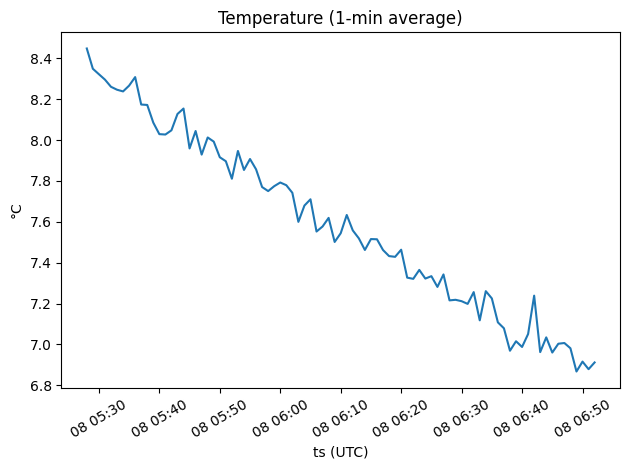

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(agg_1m.index, agg_1m["temperature_c"])
plt.title("Temperature (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("°C")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


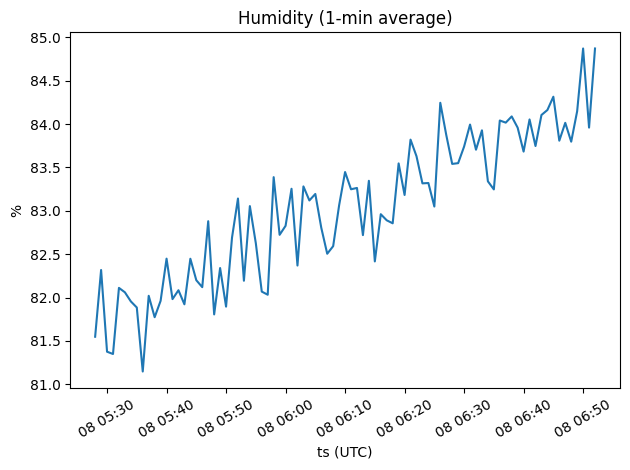

In [7]:
plt.figure()
plt.plot(agg_1m.index, agg_1m["humidity_pct"])
plt.title("Humidity (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("%")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


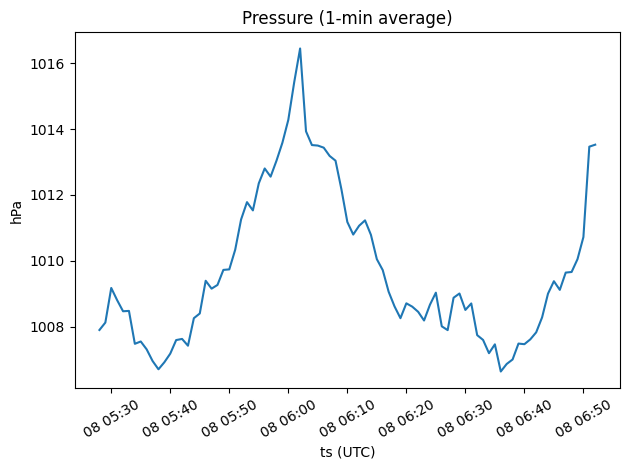

In [8]:
plt.figure()
plt.plot(agg_1m.index, agg_1m["pressure_hpa"])
plt.title("Pressure (1-min average)")
plt.xlabel("ts (UTC)")
plt.ylabel("hPa")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [9]:
df[["temperature_c","humidity_pct","pressure_hpa","wind_speed_mps","wind_dir_deg"]].corr()

,temperature_c,humidity_pct,pressure_hpa,wind_speed_mps,wind_dir_deg
temperature_c,1.000000,-0.385078,0.022965,-0.002120,0.015052
humidity_pct,-0.385078,1.000000,0.002186,-0.015673,-0.008108
pressure_hpa,0.022965,0.002186,1.000000,-0.088831,-0.325622
wind_speed_mps,-0.002120,-0.015673,-0.088831,1.000000,0.112040
wind_dir_deg,0.015052,-0.008108,-0.325622,0.112040,1.000000


## Быстрая проверка: данные поступают
Проверка поступления данных


In [10]:
pd.read_sql(text("SELECT count(*) AS n FROM weather_events;"), engine)


,n
0,6310
